In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crop-recommendation-dataset/Crop_Recommendation.csv


### Introduction:
Precision agriculture is in trend nowadays. It helps the farmers to get informed decision about the farming strategy. Therefore this dataset defines 22 different crops along with their features. Therefore, to find the most suitable crop for cropping, we will be using ML models.

### Objective:
- Exploratory Data Analysis
- Data Preprocessing for modeling
- train and test data
- Using models
- Conclusion

### Import Libraries:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

### Helping Functions:

In [3]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support,roc_curve, auc, accuracy_score

# Model Evaluation
def model_evaluation(yt, yp):
    results = {}
    results['accuracy'] = accuracy_score(yt, yp)
    
    precision, recall, fscore, _ = precision_recall_fscore_support(yt, yp, average = 'weighted')
    results['precision'] = precision
    results['recall'] = recall
    results['fscore'] = fscore
    
    metrics = list(results.keys())
    values = list(results.values())
    
    ax = sns.barplot(x = metrics, y = values, palette = 'viridis')
    plt.title('Model Evaluation Metrics')
    plt.ylim(0,1)
    plt.ylabel('Value')
    
    for i, v in enumerate(values):
        plt.text(i, v/2, f'{v: 0.2f}', ha = 'center', va = 'center', color = 'white',
                fontsize = 12)
    plt.show()

# Classification Report    
def class_report(yt, yp):
    cr = pd.DataFrame(classification_report(yt, yp, output_dict = True))
    return cr.T.style.background_gradient(cmap = 'Blues', axis = 0)

# Confusion Matrix
def conf_matrix(yt, yp):
    cm = confusion_matrix(yt, yp)
    sns.heatmap(cm, annot = True, linecolor = 'black', fmt = '0.2f', cmap = 'Blues',
               linewidths = 0.01)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

# ROC Curve
def plot_roc(yt, yp):
    fpr, tpr, thr = roc_curve(yt, yp)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize = (6,6))
    plt.plot(fpr, tpr, color = 'darkorange', lw=2,
            label = f"ROC_CURVE (Area = {roc_auc : 0.3f})")
    plt.plot([0.0, 1.0], [0.0, 1.0], lw=2, color = 'navy', linestyle = '--')
    plt.xlim([-0.01, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc - 'lower right')
    plt.show()

### Exploratory Data Analysis:

In [4]:
df = pd.read_csv(r"/kaggle/input/crop-recommendation-dataset/Crop_Recommendation.csv")
df.head().style.background_gradient(cmap = 'Blues', axis = 0)

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall,Crop
0,90,42,43,20.879744,82.002744,6.502985,202.935536,Rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,Rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,Rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,Rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,Rice


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nitrogen     2200 non-null   int64  
 1   Phosphorus   2200 non-null   int64  
 2   Potassium    2200 non-null   int64  
 3   Temperature  2200 non-null   float64
 4   Humidity     2200 non-null   float64
 5   pH_Value     2200 non-null   float64
 6   Rainfall     2200 non-null   float64
 7   Crop         2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


As per the above information we have 2200 entries along with only one categorical variable and also there is no null value in the dataset.

In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['Crop'] = label_encoder.fit_transform(df['Crop'])
df['Crop'].unique()

array([20, 11,  3,  9, 18, 13, 14,  2, 10, 19,  1, 12,  7, 21, 15,  0, 16,
       17,  4,  6,  8,  5])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nitrogen     2200 non-null   int64  
 1   Phosphorus   2200 non-null   int64  
 2   Potassium    2200 non-null   int64  
 3   Temperature  2200 non-null   float64
 4   Humidity     2200 non-null   float64
 5   pH_Value     2200 non-null   float64
 6   Rainfall     2200 non-null   float64
 7   Crop         2200 non-null   int64  
dtypes: float64(4), int64(4)
memory usage: 137.6 KB


Now using Label Encoding we have converted string variable into an integer so that model can understand.

### Univariate Data Analysis:

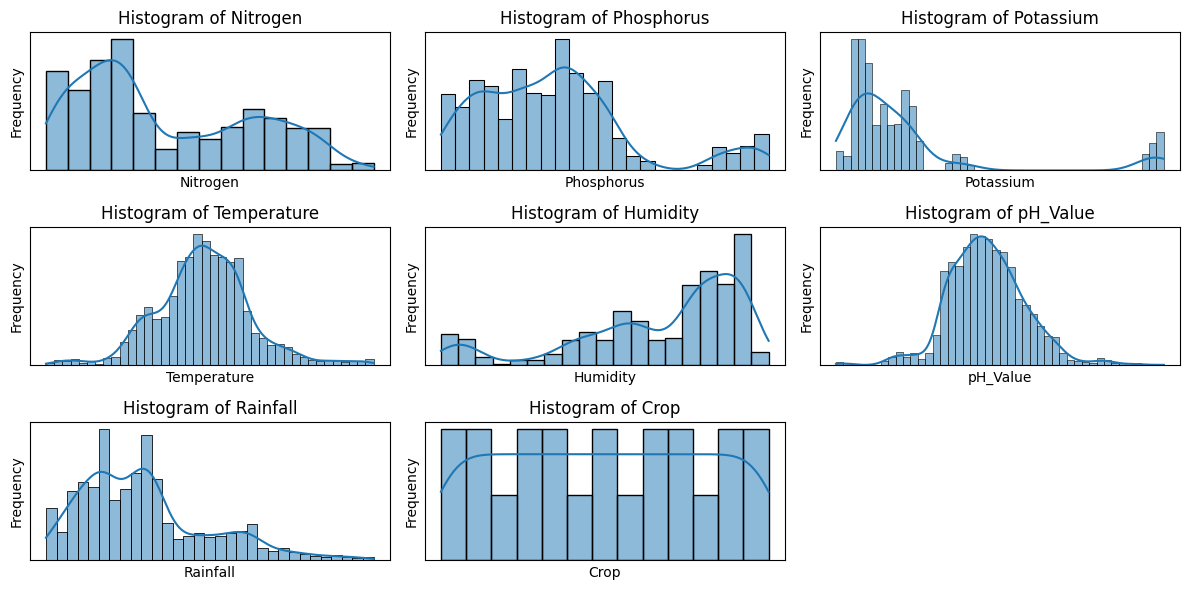

In [8]:
n = len(df.select_dtypes(include = [np.number]).columns)
nrow = int(np.ceil(n / 3))

fig, axes = plt.subplots(nrow, 3, figsize = (12,6))

for i, col in enumerate(df.select_dtypes(include = [np.number]).columns):
    ax = axes.flat[i]
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.set_xticks([])
    ax.set_yticks([])
    
for ax in axes.flat[n:]:
    ax.axis('off')
    
fig.tight_layout()
plt.show()


Figure shows that most of the dataset the skewed except Temperature, PH_value and Crop variables.

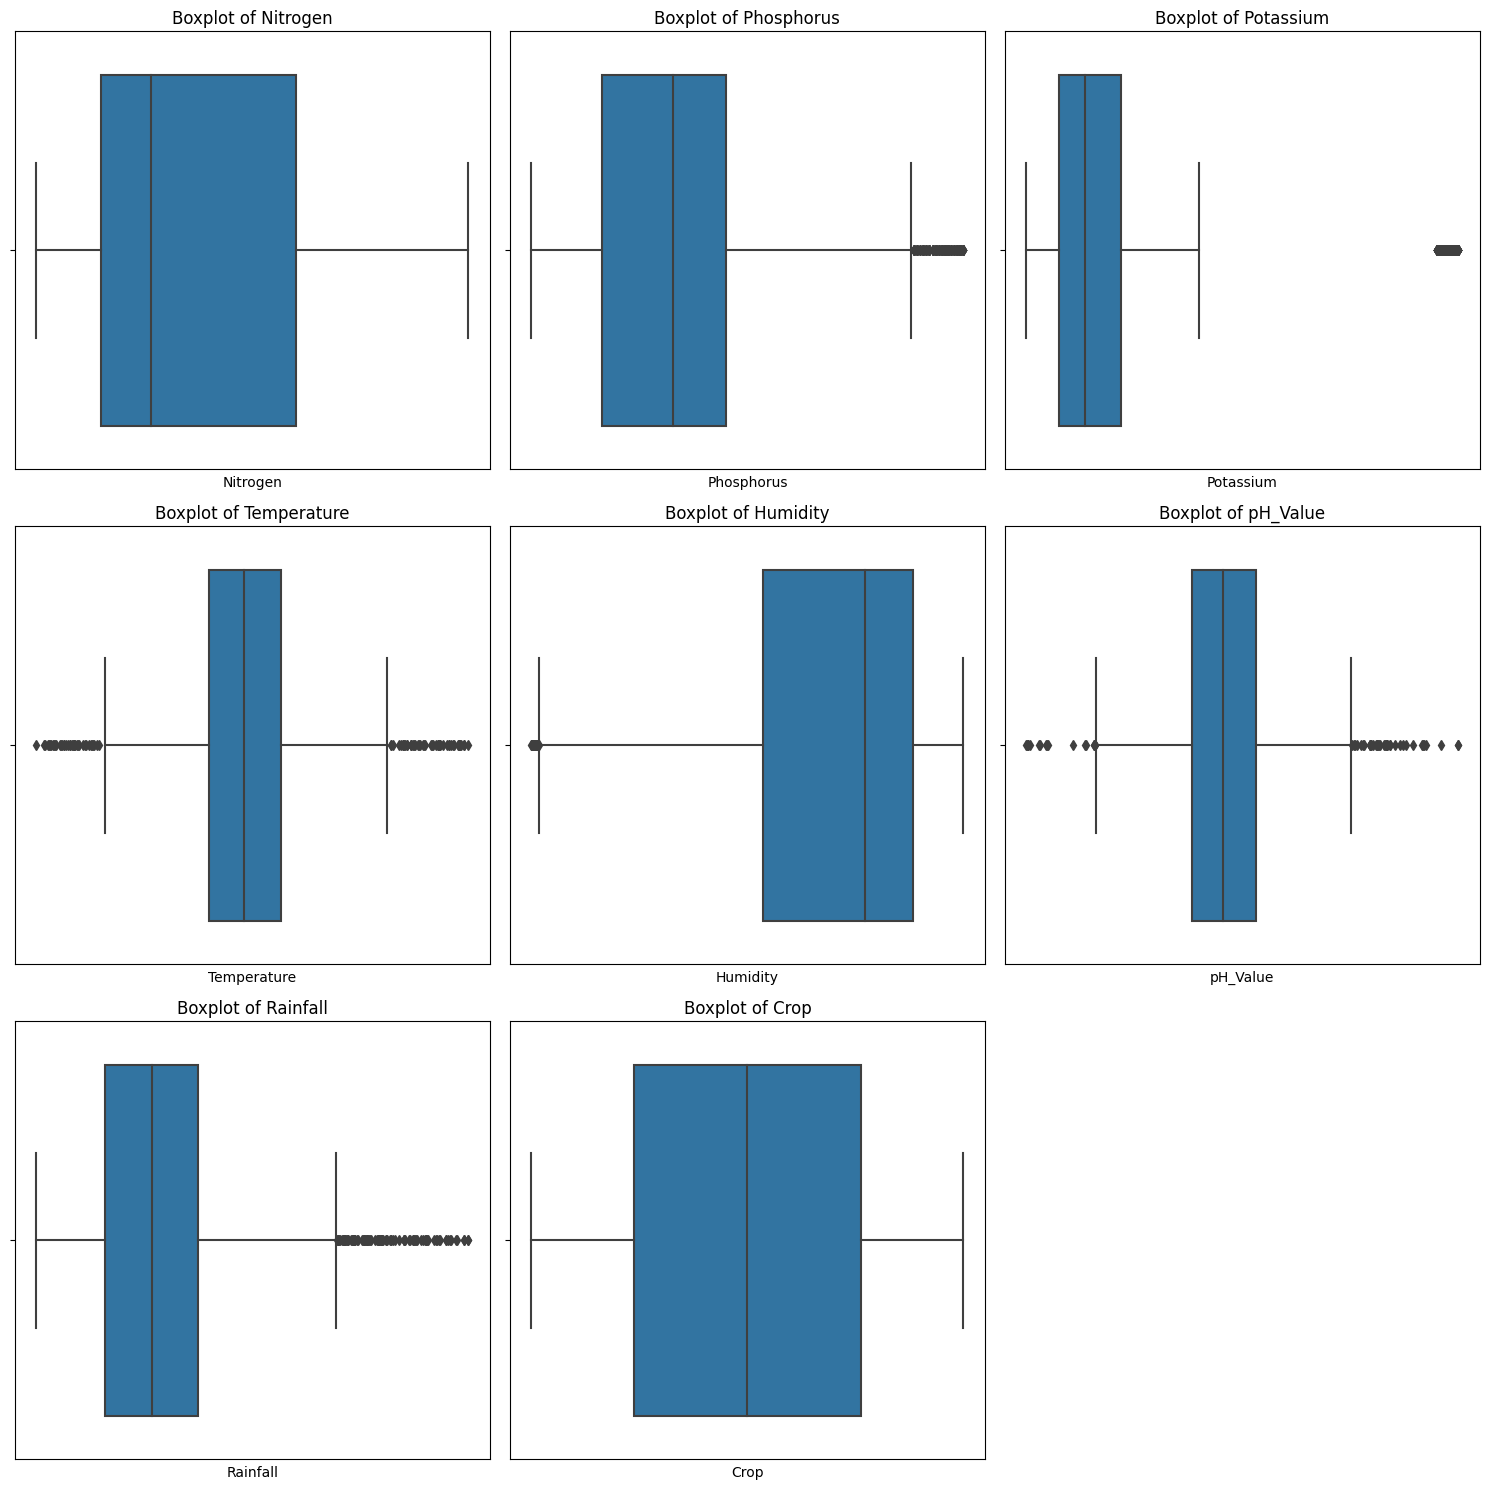

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Number of numeric columns
n = len(df.select_dtypes(include=[np.number]).columns)
nrow = int(np.ceil(n / 3))

# Create subplots
fig, axes = plt.subplots(nrow, 3, figsize=(15, 5 * nrow))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot each numeric column
for i, col in enumerate(df.select_dtypes(include=[np.number]).columns):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_xticks([])

# Turn off the axes of the remaining empty subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

fig.tight_layout()
plt.show()


Eventhough histogram provides some variables such as PH_value and Temperature are normally distributed but they show the outliers which creates bell shape curve. So boxplots show that all of the variables show shkewness due to outliers. Therefore, in preprocessing section we will solve this problem using Standard Scaler.

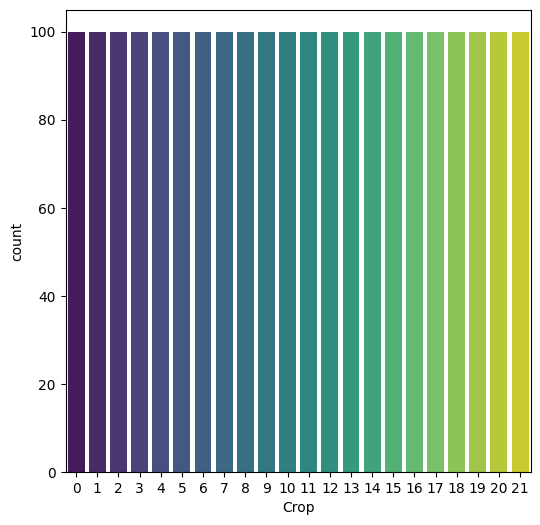

In [10]:
plt.figure(figsize = (6,6))
sns.countplot(x = df['Crop'], palette = 'viridis')
plt.show()

### Bivariate Analysis:

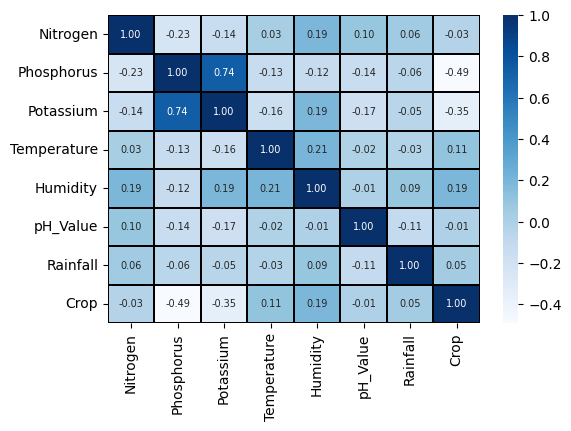

In [11]:
# Correlation Matrix:
plt.figure(figsize = (6,4))
corr = df.corr()
sns.heatmap(corr, annot = True, cmap = 'Blues', linewidths = 0.01, linecolor = 'black',
           fmt = '0.2f', annot_kws = {'fontsize' : 7})
plt.xticks(fontsize = 10, rotation = 90)
plt.yticks(fontsize = 10, rotation = 0)
plt.show()

Most of the variables have no relation to one another which is quite helpful for us because this tells that all features are important.

### Preprocessing and creating train and test sets:

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Crop'], axis = 1), df['Crop'], test_size = 0.2, random_state = 42)
print(X_train.shape)
print(y_train.shape)

(1760, 7)
(1760,)


In [13]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

X_train_scaled = std_scaler.fit_transform(X_train)
X_test_scaled = std_scaler.transform(X_test)

print(f"X_train_scaled: {X_train_scaled.shape}")
print(f"X_test_scaled: {X_test_scaled.shape}")

X_train_scaled: (1760, 7)
X_test_scaled: (440, 7)


### KNN Algorithm:

In [14]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

params_dist = {
    'n_neighbors' : [2 * n +1 for n in range(1,10)],
    'weights' : ['uniform', 'distance']
}
random_search = RandomizedSearchCV(estimator = knn, param_distributions = params_dist, cv=5,
                                  scoring = 'accuracy', n_jobs = -1, n_iter = 10)
random_search.fit(X_train_scaled, y_train.values.ravel())

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

Best Parameters: {'weights': 'uniform', 'n_neighbors': 5}
Best Score: 0.9761363636363637


In [15]:
random_search.best_estimator_

KNeighborsClassifier()

In [16]:
y_pred = random_search.predict(X_test_scaled)

# Classification Report
class_report(y_test, y_pred)

,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,23.000000
1,1.000000,1.000000,1.000000,21.000000
2,0.950000,0.950000,0.950000,20.000000
3,1.000000,1.000000,1.000000,26.000000
4,1.000000,1.000000,1.000000,27.000000
5,0.944444,1.000000,0.971429,17.000000
6,0.894737,1.000000,0.944444,17.000000
7,1.000000,1.000000,1.000000,14.000000
8,0.814815,0.956522,0.880000,23.000000
9,0.909091,1.000000,0.952381,20.000000


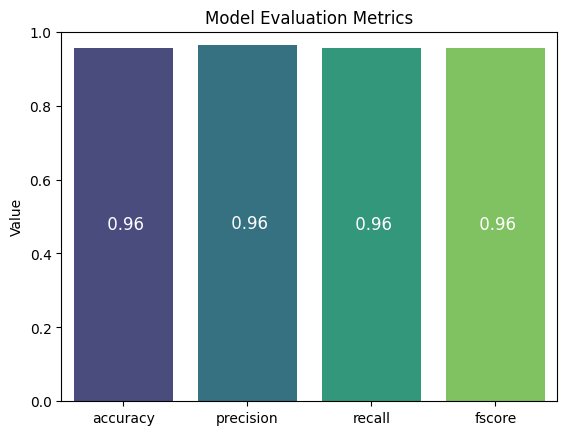

In [17]:
# Model Evaluation
model_evaluation(y_test, y_pred)

### SVM Algorithm:

In [18]:
from sklearn.svm import SVC

svm = SVC(probability = True)

params_dist = {
    'C' : [0, 0.01, 0.1, 10, 50, 70, 100],
    'kernel' : ['linlinear', 'poly', 'rbf', 'sigmoid'],
    'class_weight' : [None, 'balanced']
}

random_search = RandomizedSearchCV(estimator = svm, param_distributions = params_dist,
                                  cv=5, scoring = 'accuracy', n_jobs = -1, n_iter = 10)
random_search.fit(X_train_scaled, y_train.values.ravel())

print(f"Best Parameters : {random_search.best_params_}")
print(f"Best score: {random_search.best_score_}")

Best Parameters : {'kernel': 'rbf', 'class_weight': None, 'C': 0.1}
Best score: 0.9448863636363637


In [19]:
random_search.best_estimator_

SVC(C=0.1, probability=True)

In [20]:
y_pred = random_search.predict(X_test_scaled)

class_report(y_test, y_pred)

,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,23.000000
1,1.000000,1.000000,1.000000,21.000000
2,0.863636,0.950000,0.904762,20.000000
3,1.000000,1.000000,1.000000,26.000000
4,0.964286,1.000000,0.981818,27.000000
5,1.000000,1.000000,1.000000,17.000000
6,0.944444,1.000000,0.971429,17.000000
7,1.000000,1.000000,1.000000,14.000000
8,0.718750,1.000000,0.836364,23.000000
9,0.909091,1.000000,0.952381,20.000000


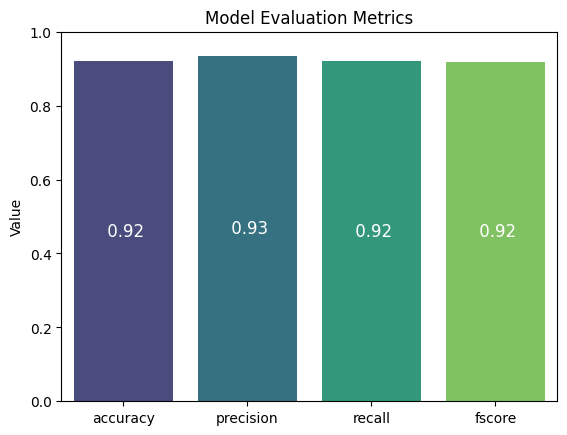

In [21]:
model_evaluation(y_test, y_pred)

### Decision Tree Algorithm:

In [22]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state = 42)

params_dist = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [2 * n for n in range(1,21)],
    'min_samples_leaf' : [n for n in range(1,11)]
}

random_search = RandomizedSearchCV(estimator = dt, param_distributions = params_dist,
                                  cv=5, n_jobs = -1, n_iter = 10, scoring = 'accuracy')
random_search.fit(X_train_scaled, y_train.values.ravel())

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")


Best Parameters: {'min_samples_leaf': 2, 'max_depth': 12, 'criterion': 'gini'}
Best Score: 0.9852272727272726


In [23]:
random_search.best_estimator_

DecisionTreeClassifier(max_depth=12, min_samples_leaf=2, random_state=42)

In [24]:
y_pred = random_search.predict(X_test_scaled)

# Classification Report
class_report(y_test, y_pred)

,precision,recall,f1-score,support
0,1.000000,1.000000,1.000000,23.000000
1,1.000000,1.000000,1.000000,21.000000
2,0.909091,1.000000,0.952381,20.000000
3,1.000000,1.000000,1.000000,26.000000
4,0.964286,1.000000,0.981818,27.000000
5,1.000000,1.000000,1.000000,17.000000
6,1.000000,1.000000,1.000000,17.000000
7,1.000000,1.000000,1.000000,14.000000
8,0.916667,0.956522,0.936170,23.000000
9,1.000000,1.000000,1.000000,20.000000


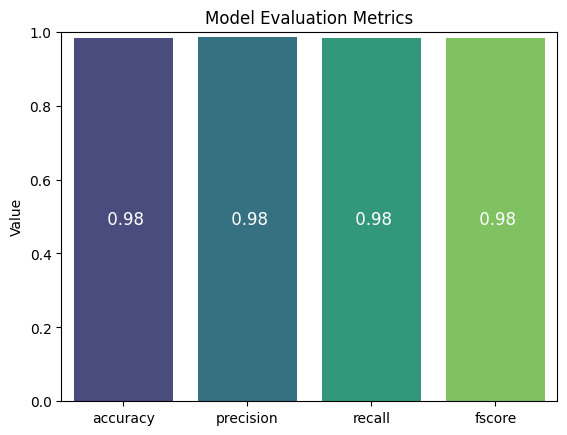

In [25]:
# Model Evaluation
model_evaluation(y_test, y_pred)

### Conclusion:
The trained models KNN, SVM and Decosion Tree provide quite intriguing results. However, we require more accurate model for the Crop selection for cropping. Therefore, we find that Decision Tree is more quilified in predicting Crop than KNN and SVM.